In [ ]:
# Kayla Bachler
# 12-10-2018
# CSS490 Final Project

############################## IMPORT LIBRARIES ###############################
#import os
#os.environ["PATH"] += os.pathsep + 'K:/Program Files (x86)/Graphviz/release/bin'
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder  # For categorical data
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Import tools needed for visualization
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
import pydot
import seaborn as sns
import itertools
from pandas_ml import ConfusionMatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
################################################################################

# Import the dataset
df = pd.read_csv('Global_Landslide_Final.csv')
df.shape # See how many data objects & attributes we have
df.head(5) # View first 5 data objects
df.landslide_trigger.unique() #See how many unique triggers we have

############################### DATA PREPROCESSING ###############################
# In this section I performed data preprocessing by removing noise, replacing NaN
# values, replacing NaN/empty values with the median of that attribute and dropping
# columns that wouldn't help our model train
##################################################################################
# Remove unwanted columns
df = df.drop(columns=['formatted_date','event_date','event_day','event_title',
                      'event_id','event_description','location_description',
                      'location_accuracy','gazeteer_closest_point', 'country_code','gazeteer_distance'])
df = df.dropna(subset=['landslide_trigger'])

# Replace NaN values in fatality & injury count with the medians
df['fatality_count'].fillna((df['fatality_count'].median()), inplace=True)
df['injury_count'].fillna((df['injury_count'].median()), inplace=True)
df['population'].fillna((df['population'].median()), inplace=True)
df.isnull().sum() # check for missing values in dataset

# Delete attribute values that we don't want to classify:
df = df[df.landslide_size != "catastrophic"]
df = df[df.landslide_category != "unknown"]
df = df[df.landslide_category != "other"]
df = df[df.country_name != "NaN"]

# Update trigger values so reduce unnessessary unique values
df['event_time'] = df['event_time'].replace('unknown', 'NaN')

# Update landlside size values so reduce unnessessary unique values
df['landslide_size'] = df['landslide_size'].replace('very_large', 'large')
print('Landslide triggers:', df.landslide_trigger.unique())

# Print graph showing imbalanced data:
pd.value_counts(df['landslide_trigger']).plot.bar()
plt.title('Landslide Trigger Distribution')
plt.xlabel('Class')
plt.ylabel('Data Objects')
df['landslide_trigger'].value_counts()

# Make sure all categorical data is string value only
df['event_time'] = df['event_time'].astype(str)
df['landslide_category'] = df['landslide_category'].astype(str) 
df['country_name'] = df['country_name'].astype(str) #make sure all country name values are strings

# Label Encode our categorical data with dummy variables
df = pd.get_dummies(df, prefix=['event_time','country_name','landslide_category','landslide_size'], 
                    columns=['event_time','country_name','landslide_category','landslide_size'])

# Label Encode our trigger values into numbers
df["landslide_trigger"] = df["landslide_trigger"].astype('category')
df["landslide_trigger"] = df["landslide_trigger"].cat.codes
df.head(5)

# Split our labels into their own array
Y = np.array(df['landslide_trigger'])  # values we want to predict
# Remove the labels from the features, axis 1 refers to the col
df = df.drop('landslide_trigger',axis=1)

# Save the column headers 
feature_list = list(df.columns)
X = df.as_matrix() # Holds our data objects and attributes

# Splitting dataset into training and test set
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size =.20)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
print("Before OverSampling, counts of label '0': {}".format(sum(train_labels==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(train_labels==1)))
print("Before OverSampling, counts of label '2': {}".format(sum(train_labels==2)))
print("Before OverSampling, counts of label '3': {}".format(sum(train_labels==3)))
print("Before OverSampling, counts of label '4': {}".format(sum(train_labels==4)))
print("Before OverSampling, counts of label '5': {}".format(sum(train_labels==5)))
print("Before OverSampling, counts of label '6': {}".format(sum(train_labels==6)))
print("Before OverSampling, counts of label '7': {}".format(sum(train_labels==7)))

#sm = SMOTE(random_state=0, sampling_strategy='auto', k_neighbors=5)
sm = ADASYN(sampling_strategy='auto')
train_features_res, train_labels_res = sm.fit_sample(train_features, train_labels.ravel())
sm_svm = SMOTE(kind='svm',sampling_strategy='all')
X_smote, Y_smote = sm.fit_sample(train_features, train_labels)

print('After OverSampling, the shape of train_features: {}'.format(train_features_res.shape))
print('After OverSampling, the shape of train_labels: {} \n'.format(train_labels_res.shape))
print("After OverSampling, counts of label '0': {}".format(sum(train_labels_res==0)))
print("After OverSampling, counts of label '1': {}".format(sum(train_labels_res==1)))
print("After OverSampling, counts of label '2': {}".format(sum(train_labels_res==2)))
print("After OverSampling, counts of label '3': {}".format(sum(train_labels_res==3)))
print("After OverSampling, counts of label '4': {}".format(sum(train_labels_res==4)))
print("After OverSampling, counts of label '5': {}".format(sum(train_labels_res==5)))
print("After OverSampling, counts of label '6': {}".format(sum(train_labels_res==6)))
print("After OverSampling, counts of label '7': {}".format(sum(train_labels_res==7)))


############################### GRID SEARCH ######################################
# The following code uses GridSearchCV to find the best hyperparameters for our models.
# This is currently commented out since it takes several minutes to compute.
##################################################################################
'''
# Set the parameters by cross-validation
tuned_parameters = [{'n_estimators': [100, 200, 500, 1000, 1500], 
                     'max_features': ['auto', 'sqrt', 'log2'],
                     'min_samples_leaf': [50, 75, 100, 150],
                     'random_state': [0, 50],
                     'class_weight': ['balanced', 
                                    {0:100, 1:100, 2:100, 3:1000, 4:10, 5:1, 6:10, 7:10},
                                    {0:1, 1:1, 2:1, 3:1, 4:1, 5:.01, 6:.1, 7:.1}]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(train_features, train_labels)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_labels, clf.predict(test_features)
    print(classification_report(y_true, y_pred))
    print()
'''


###############################  MODEL TRAINING  ###############################
# This section contains the model training completed for both our random forest
# and svm classifiers. Following the model performance is an evaluation of each
# model's performance on the test set which is printed to the console.
#################################################################################
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=1500, random_state=50, min_samples_leaf=75,
                            class_weight='balanced')
# SVM
svclassifier = SVC(kernel='rbf', class_weight='balanced', C=1.0, random_state=0, 
                   decision_function_shape = 'ovo')

# Train our models on the training data
rf.fit(train_features_res, train_labels_res.ravel()); # Build a forest of trees from training set
svclassifier.fit(X_smote, Y_smote)  
y_pred = svclassifier.predict(test_features) 

############################### FUNCTIONS USED  ###############################
# These are definitions for functions that are used above.
# evaluate - prints the accuracy, recall, and average error for the passed model
# model_report - prints a classification report and confusion matrix
#################################################################################
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    recall = 100 * recall_score(test_labels, predictions, average='macro')
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('Recall = {:0.2f}%.'.format(recall))
    return accuracy

def model_report(model_predictions):
    triggers = [0,1,2,3,4,5,6,7]
    print(classification_report(test_labels, model_predictions,
                            triggers))
    confusion_matrix = ConfusionMatrix(test_labels, model_predictions)
    print("Confusion Matrix:\n%s" % confusion_matrix)

#################################################################################    

rf_accuracy = evaluate(rf, test_features, test_labels)
svm_accuracy = evaluate(svclassifier, test_features, test_labels)
print('Improvement of {:0.2f}%.'.format( 100 * (rf_accuracy - svm_accuracy) / svm_accuracy))

# Use the forest's predict method on the test data
rf_predictions = rf.predict(test_features)
svclassifier_predictions = svclassifier.predict(test_features)

# Print the classification report and confusion matrix for each model
model_report(rf_predictions)
model_report(svclassifier_predictions)    
    
    
    
############################### ADDITIONAL CODE FOR VISUALIZATIONS  ##################################
# This code is ommitted from above because it was used to display visualizations. I have commented 
# out this code since it takes several minutes to compile. Descriptions are written above each function.
#####################################################################################################    
    
'''
# Pull out one tree from the forest and save it to our destination folder
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree_sample.png')


# -------------------------------------------------------------------------------------
# Method to display the results of Grid Search found here:
# https://www.kaggle.com/grfiv4/displaying-the-results-of-a-grid-search
# By: George Fisher
# -------------------------------------------------------------------------------------
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

grid_clf = GridSearchCV(estimator  = SVC(), 
                        param_grid = {'C': range(1,10)}, 
                        cv         = 10)

_ = grid_clf.fit(train_features, train_labels)

GridSearch_table_plot(grid_clf, "C", negative=False)
# -----------------------------------------------------------------------------------

# Print graph showing balanced data:
unique_elements, counts_elements = np.unique(train_labels_res, return_counts=True)
pd.value_counts(train_labels_res).plot.bar()
plt.title('Landslide Trigger Oversampling Data Balance')
plt.xlabel('Class')
plt.ylabel('Frequency')


'''

Landslide triggers: ['Construction' 'Earthquake' 'Flooding' 'Mining' 'Monsoon' 'Rain' 'Snow'
 'Tropical_Cyclone']
Training Features Shape: (7304, 180)
Training Labels Shape: (7304,)
Testing Features Shape: (1826, 180)
Testing Labels Shape: (1826,)
Before OverSampling, counts of label '0': 71
Before OverSampling, counts of label '1': 65
Before OverSampling, counts of label '2': 58
Before OverSampling, counts of label '3': 75
Before OverSampling, counts of label '4': 102
Before OverSampling, counts of label '5': 6374
Before OverSampling, counts of label '6': 108
Before OverSampling, counts of label '7': 451
After OverSampling, the shape of train_features: (51031, 180)
After OverSampling, the shape of train_labels: (51031,) 

After OverSampling, counts of label '0': 6355
After OverSampling, counts of label '1': 6390
After OverSampling, counts of label '2': 6382
After OverSampling, counts of label '3': 6377
After OverSampling, counts of label '4': 6388
After OverSampling, counts of label '

Confusion matrix:
Predicted  0  1  2  3   4     5   6    7  __all__
Actual                                           
0          2  0  0  0   0    16   0    0       18
1          0  6  0  0   0    13   1    1       21
2          0  0  0  0   0    20   0    0       20
3          0  0  0  5   0    14   0    0       19
4          0  0  0  0   6    18   0    1       25
5          0  3  3  2   9  1526   3   36     1582
6          0  0  0  0   0    22  10    0       32
7          0  0  0  0   0    40   0   69      109
__all__    2  9  3  7  15  1669  14  107     1826


AttributeError: 'BinaryConfusionMatrix' object has no attribute 'pretty_format'

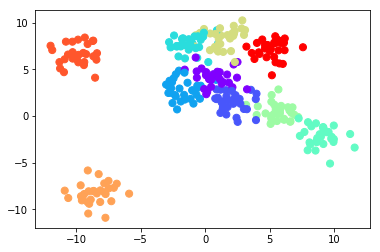

In [21]:
from sklearn.datasets import make_blobs

X, Y = make_blobs(n_samples=300, centers=10,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='rainbow');

ValueError: Number of features of the model must match the input. Model n_features is 206 and input n_features is 2 

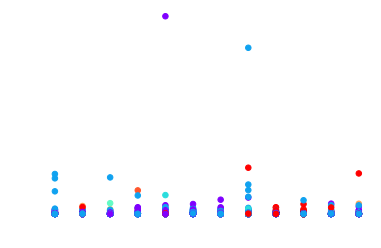

In [23]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

visualize_classifier(rf, train_features, train_labels);

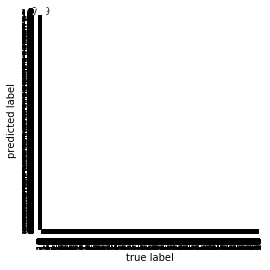

In [26]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test_labels, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train_labels,
            yticklabels=train_labels)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [43]:
from sklearn.metrics import classification_report
triggers = [1,2,3,4,5,6,7,8,9,10]
print(classification_report(test_labels, predictions,
                            triggers))

              precision    recall  f1-score   support

           1       0.56      0.50      0.53       631
           2       0.67      0.08      0.15        24
           3       0.65      0.77      0.71       935
           4       1.00      0.22      0.36        23
           5       0.00      0.00      0.00        23
           6       0.50      0.11      0.18         9
           7       0.25      0.12      0.16        17
           8       0.50      0.19      0.28        31
           9       0.42      0.17      0.24        30
          10       0.55      0.59      0.57       109

   micro avg       0.61      0.61      0.61      1832
   macro avg       0.51      0.27      0.32      1832
weighted avg       0.60      0.61      0.59      1832



ValueError: Could not interpret input 'x'